In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
from dgutils import colors as colortools
from dgutils import savehtml
from pimcscripts import pimchelp

# Notebook display options
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
#sorted(plt.style.available)
plt.style.use('classic')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Reduce the data over temperature and laod the resulting files

In [2]:
sim_params = {'τ':0.007, 'N':2, 'n':0.2}
prod_param = {'τ':0.002, 'N':2, 'n':0.1}


In [3]:
julia_root_dir = './JULIA/test/RESULTS/' + str(sim_params['τ'])
julia_data_dir = julia_root_dir + '/data/'
julia_plot_dir = julia_root_dir + '/plot/'
print(julia_data_dir)
!reduce-one.py -r T -N {sim_params['N']} -s 0.2 -n {sim_params['n']} -t {sim_params['τ']} --canonical {julia_data_dir}

./JULIA/test/RESULTS/0.007/data/
Reduced estimator over 20 Temperature value(s).
Reduced lineardensity over 20 Temperature value(s).


In [4]:
prod_root_dir = './JULIA/base/OUTPUT/02'
prod_data_dir = prod_root_dir + '/data/'
prod_plot_dir = prod_root_dir + '/plot/'
print(prod_data_dir)
!reduce-one.py -r T -N {prod_param['N']} -s 0.2 -n {prod_param['n']} -t {prod_param['τ']} --canonical {prod_data_dir}

./JULIA/base/OUTPUT/02/data/
Reduced lineardensity over 29 Temperature value(s).
Reduced virial over 29 Temperature value(s).


In [5]:
est_reduce_name = pimchelp.get_reduce_name(**sim_params, canonical=True, reduce='T', estimator='estimator')
estimator = pimchelp.PIMCResults(f'{julia_data_dir}{est_reduce_name}')
rho_reduce_name = pimchelp.get_reduce_name(**sim_params, canonical=True, reduce='T', estimator='lineardensity')
rho = pimchelp.PIMCResults(f'{julia_data_dir}{rho_reduce_name}')

In [6]:
prod_est_reduce_name = pimchelp.get_reduce_name(**prod_param, canonical=True, reduce='T', estimator='virial')
prod_estimator = pimchelp.PIMCResults(f'{prod_data_dir}{prod_est_reduce_name}')
prod_rho_reduce_name = pimchelp.get_reduce_name(**prod_param, canonical=True, reduce='T', estimator='lineardensity')
prod_rho = pimchelp.PIMCResults(f'{prod_data_dir}{prod_rho_reduce_name}')

## Study the Energy vs. Temperature

In [16]:
#E = lambda T: sim_params['N'] * 0.5/np.tanh(0.5/T)
#eps = 0.0
#for i in range(10):
#    eps += i + 0.5
#
#def exp3eo2T(eps, T):
#    return np.exp(-3.0 * eps / (2.0 * T))

#E = lambda T: ( 4.0*eps*exp3eo2T(eps, T)*np.sinh(eps/(2.0*T)) + 0.5 + eps/np.tanh(eps/(2.0*T)) ) / ( 1 + 2.0*exp3eo2T(eps, T) * np.sinh(eps/(2.0*T)) )
def High_Temp(N, T):
    return N*T

def Low_Temp(T):
    return 1.0/(np.exp(1.0/T)-1.0)

def Sum(N, T):
    total = 0.0
    for k in range(1,N+1):
        total += k / (np.exp(k / T) - 1.0)
    
    return total

fE = lambda N, T: N*N/2.0 + Sum(N, T)
fEperN = lambda N, T: N/2.0 + Sum(N, T)/N

bE = lambda N, T: N/2.0 + Sum(N, T)
bEperN = lambda N, T: 1/2.0 + Sum(N, T)/N

fHigh = lambda N, T: N*N/2.0 + High_Temp(N, T)
fHighPerN = lambda N, T: N/2.0 + High_Temp(N, T)/N

bHigh = lambda N, T: N/2.0 + High_Temp(N, T)
bHighPerN = lambda N, T: 1.0/2.0 + High_Temp(N, T)/N

fLow = lambda N, T: N*N/2.0 + Low_Temp(T)
fLowPerN = lambda N, T: N/2.0 + Low_Temp(T)/N

bLow = lambda N, T: N/2.0 + Low_Temp(T)
bLowPerN = lambda N, T: 1/2.0 + Low_Temp(T)/N

T_max = 10
_T = np.linspace(1E-2,T_max,1000)

In [17]:
print(fE(2, 5))

10.583145129566468


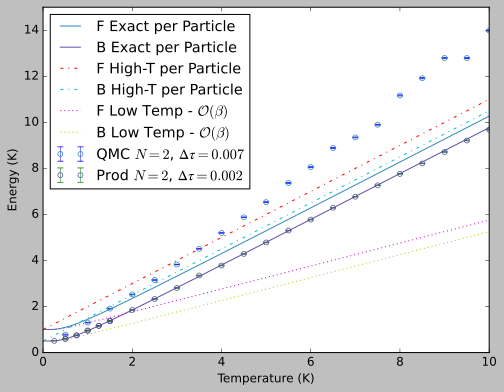

In [18]:
fparams = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None', 'mew':0.75, 'mec':colors[2]}
bparams = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None', 'mew':0.75, 'mec':colors[0]}

### QMC Data ###
T = estimator.data['T']
T_prod = prod_estimator.data['T']
plt.errorbar(T, estimator.data['E']/2, yerr=estimator.data['ΔE'], **fparams, label=f"QMC $N={sim_params['N']}$, $Δτ={sim_params['τ']}$")
plt.errorbar(T_prod, prod_estimator.data['E/N'], yerr=prod_estimator.data['ΔE/N'], **bparams, label=f"Prod $N={prod_param['N']}$, $Δτ={prod_param['τ']}$")

### Exact + Approx Solutions w/ fill_between ###
plt.plot(_T, fEperN(sim_params['N'], _T), lw=1, color=colors[2], label='F Exact per Particle')
plt.plot(_T, bEperN(prod_param['N'], _T), lw=1, color=colors[0], label='B Exact per Particle')

plt.plot(_T, fHighPerN(sim_params['N'], _T), label='F High-T per Particle', ls='-.')
#plt.fill_between(_T, fE(sim_params['N'], _T), fHigh(sim_params['N'], _T), alpha=0.1)
plt.plot(_T, bHighPerN(prod_param['N'], _T), label='B High-T per Particle', ls='-.')
#plt.fill_between(_T, bE(prod_param['N'], _T), bHigh(prod_param['N'], _T), alpha=0.1)

plt.plot(_T, fLowPerN(sim_params['N'], _T), ls=':', label=r'F Low Temp - $\mathcal{O}(\beta)$')
#plt.fill_between(_T, fE(sim_params['N'], _T), fLow(sim_params['N'], _T), alpha=0.1)
plt.plot(_T, bLowPerN(prod_param['N'], _T), ls=':', label=r'B Low Temp - $\mathcal{O}(\beta)$')
#plt.fill_between(_T, bLow(prod_param['N'], _T), bE(prod_param['N'], _T), alpha=0.1)

#plt.axvline(2.0, color='red', ls='--')
#plt.axvline(4*np.pi, color='blue', ls='-')

### Plot Scaling, labeling, etc. ###
plt.xlim(0,10)
plt.ylim(0.0,15)
plt.ylabel('Energy (K)')
plt.xlabel('Temperature (K)')
plt.legend(loc='upper left')
plt.savefig(julia_plot_dir + 'E_vs_T_SHO_N' + str(sim_params['N']) + '.png', dpi=300)

## Investigate the probaility density

In [10]:
rho_exact = lambda x,T: np.exp(-x**2*np.tanh(0.5/T))/np.sqrt(np.pi/np.tanh(0.5/T))
_x = np.linspace(-5,5,1000)

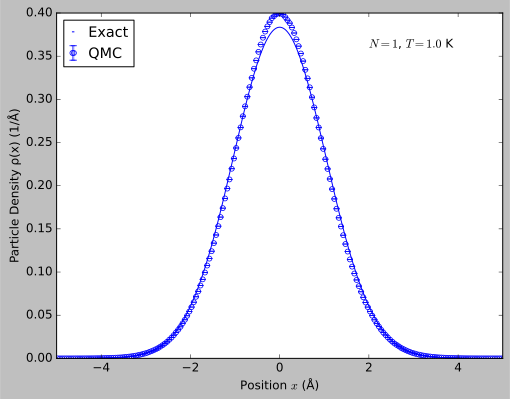

In [11]:
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':5, 'lw':0.75, 'ls':'None', 'mew':0.75, 'mec':colors[0]}

T_compare = 1.0
idx = np.where(np.abs(T-T_compare) < 0.01)[0][0]
x,rhox,drhox = rho.epdata(rho.params[idx])
norm = scipy.integrate.simps(rhox,x)
deltaX = x[2] - x[1]

fig,ax = plt.subplots()

ax.errorbar(x+deltaX/2,rhox/norm,yerr=drhox,**params, label=f'QMC')
ax.plot(_x, rho_exact(_x, T_compare), '-', lw=1, color=colors[0], label = 'Exact')
ax.text(0.7,0.9, f'$N=1$, $T={T_compare}$ K', fontsize=12, transform=ax.transAxes)
ax.set_xlim(-5,5)
ax.set_xlabel('Position $x$ (Å)')
ax.set_ylabel('Particle Density ρ(x) (1/Å)')
ax.legend(loc='upper left', handlelength=0.5)
plt.savefig(julia_plot_dir + 'rho_vs_xT_1.5_SHO_NA.png', dpi=300)

## Now let's make a grid for all temperatures

In [12]:
colors = colortools.get_linear_colors('Spectral',len(T),reverse=True)
params = {'mfc':'None', 'elinewidth':0.5, 'marker':'o', 'ms':3, 'lw':0.75, 'ls':'None', 'mew':0.75}

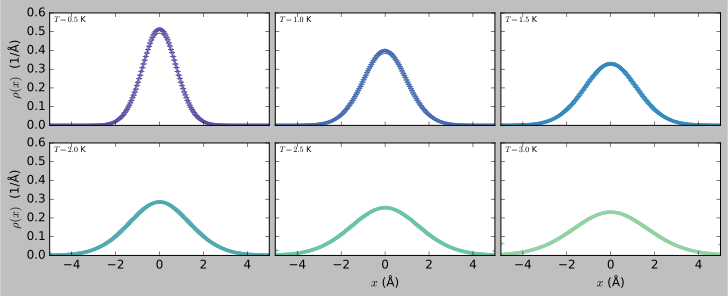

In [13]:
figsize = (10,4)
fig,axes = plt.subplots(nrows=2,ncols=3,sharex=True,sharey=True,constrained_layout=True,squeeze=True, figsize=figsize)
for i, ax in enumerate(axes.flat):
	cT = T[i]
	x,rhox,drhox = rho.epdata(rho.params[i])
	norm = scipy.integrate.simps(rhox,x)
	ax.errorbar(x+deltaX/2,rhox/norm,yerr=drhox, **params, label=f'QMC', mec=colors[i], ecolor=colors[i])
	ax.plot(_x, rho_exact(_x,cT), '-', lw=1, color=colors[i], label='Exact')
	ax.set_xlim(-5,5)
	ax.text(0.02, 0.92,f'$T={cT}$ K',transform=ax.transAxes, fontsize=8)
	if i > 3:
		ax.set_xlabel('$x$ (Å)')

axes[0,0].set_ylabel(r'$\rho(x)$  (1/Å)')
axes[1,0].set_ylabel(r'$\rho(x)$  (1/Å)');

plt.savefig(julia_plot_dir + 'rho_vs_xT_SHO_N' + str(sim_params['N']) + '.png', dpi=300)

## Quantifying with $\chi^2$

In [14]:
chi2 = []
for iT, cT in enumerate(T):
	x,rhox,drhox = rho.epdata(rho.params[iT])
	norm = scipy.integrate.simps(rhox,x)
	x+= deltaX/2
	chi2.append(np.average(((rho_exact(x,cT) - rhox/norm))**2))

chi2 = np.array(chi2)

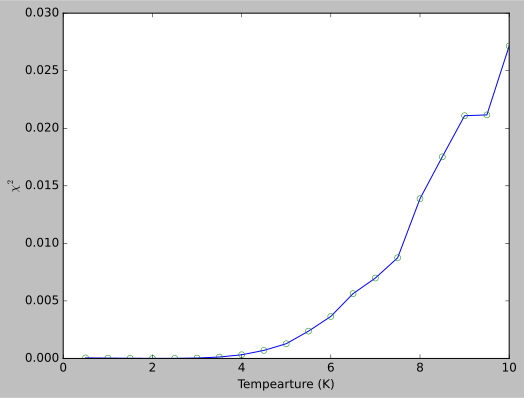

In [15]:
plt.plot(T,chi2)
plt.plot(T,chi2,'o',fillstyle='none')
plt.ylabel(r'$\chi^2$')
plt.xlabel('Tempearture (K)')
plt.savefig(julia_plot_dir + 'chi2_vs_T_SHO_N' + str(sim_params['N']) + '.png',dpi=300)